# Shor's Algorithm

This algorithm aims to find the non-trivial factors of a composite $N$.<br>
It uses classical computation with the quantum sub-routine, order-finding algorithm, which we first consider.

## Order finding algorithm

Given a number $n$, we consider the group $(\mathbb{Z}/n\mathbb{Z})^\times$, which contains the residue classes modulo $n$ which are co-prime with $n$. Given any $a$ in this group, we aim to find its order $r$, that is, the smallest positive integer such that $a^r = 1 \pmod n$.<br>

The strategy behind this is to construct a unitary gate $U$ which contains $r$ in the phase of an eigenvalue, which can be found by the phase estimation algorithm. Let $l = \lceil \log_2 n\rceil$, we choose $U$ such that:
$$
\begin{align*}
U|x\rangle &= |ax\bmod n\rangle \quad \text{for $0\leq x \leq n-1$}\\
U|x\rangle &= |x\rangle \quad \text{for $n\leq x\leq 2^l - 1$}
\end{align*}
$$
It can be shown that $U$ is unitary. Also:
$$
U\sum\limits_{k=0}^{r-1}\frac{1}{\sqrt r}\exp\left(-i\frac{2\pi s}{r}k\right)|a^k\bmod n\rangle = U|u_s\rangle = \exp\left(i\frac{2\pi s}{r}\right)|u_s\rangle
$$
$$\sum\limits_{s=0}^{r-1}|u_s\rangle = |1\rangle$$

Thus, $|1\rangle$ is a state which is in a uniform superposition of the eigenstates of $U$ with eigenvalues $\exp(i2\pi s/r)$, $s= \{0, 1, 2,\ldots ,r-1\}$. And running the phase estimation algorithm will give us the values $2^t\frac{s}{r}$ with equal probabilities.

In [84]:
from qiskit import QuantumCircuit, assemble, Aer, transpile
from fractions import Fraction
import numpy as np
from qiskit.visualization import plot_histogram, plot_bloch_vector, array_to_latex, plot_bloch_multivector
from math import sqrt, pi, gcd
from IPython.display import display, Math
from qiskit.quantum_info import random_statevector
svsim = Aer.get_backend('aer_simulator')

def reverse(qc, n):
    for i in range(0, n//2):
        qc.swap(i, n - 1 - i)

def inv_QFT(n):
    qc = QuantumCircuit(n)
    for i in range(n):
        for j in range(1 + i, 1, -1):
            qc.cp(-2*np.pi/(2**j), (i - (j - 1)), i)
        qc.h(i)
    qc.name = "inv QFT"
    return qc

## The gate U

In general, for estimation upto $t$ digits, we would need to implement controlled $U^{2^j}, j\in\{0, 1, 2, \ldots, t-1\}$ gates. After the action of all these gates, $|z\rangle|y\rangle\rightarrow |z\rangle|a^z y\bmod n\rangle$. The task of implementing these gates is non-trivial in general, and relies on modular exponentiation, and multiplication circuits.<br>

Here we consider only the specific case of $n=15$. Since, the inputs to all the $U$ gates in our circuit will be a superposition of $|k\rangle$ s with $k, n$ coprime, we can get away with "incorrectly" defining the action of $U$ on (here) eg. $|0\rangle$ and $|15\rangle$.<br>

Consider the state $|y\rangle$ in binary as $|y_3y_2y_1y_0\rangle$. 

For $a = 2$: $2y \equiv y_3y_2y_1y_00 = y_2y_1y_00 + 16y_3 = y_2y_1y_0y_3 \bmod 15$.

Similarly, for $a=4$: $4y = y_3y_2y_1y_000 = 32y_3 + 16y_2 + y_1y_000 = 2y_3 + y_2 + y_1y_000\bmod 15 = y_1y_0y_3y_2\bmod 15$.

For $a=8$: $8y = y_0y_3y_2y_1\bmod 15$

For $a=7$: $7y = -8y\bmod 15 = 1111-y_0y_3y_2y_1\bmod 15 = \neg y_0\neg y_3\neg y_2\neg y_1\bmod 15$

Similarly, for $a=11 = 15-4$: $11y = \neg y_1\neg y_0\neg y_3\neg y_2\bmod 15$.

For $a=13$: $13y = \neg y_2\neg y_1\neg y_0\neg y_3\bmod 15$

For $a=14$: $14y = \neg y_3\neg y_2\neg y_1\neg y_0\bmod 15$

These actions are not correct for $y = 0, 15$ in the last 3 cases, but it won't matter.

Thus, we have our $U$ gate for all possible values of $a$ for $n=15$.

In [85]:
def func(qc, idx, a):
    if a == 1:
        return
    if a == 2 or a == 13:
        qc.swap(idx+3, idx+2)
        qc.swap(idx+2, idx+1)
        qc.swap(idx+1, idx)
    elif a == 4 or a == 11:
        qc.swap(idx+3, idx+1)
        qc.swap(idx+2, idx)
    elif a == 8 or a == 7:
        qc.swap(idx+3, idx)
        qc.swap(idx+1, idx)
        qc.swap(idx+2, idx+1)
    if a % 2 == 1 or 14:
        for i in range(4):
            qc.x(idx+i)

def mod15_power(a, p):
    U = QuantumCircuit(4)
    for i in range(p):
        func(U, 0, a)
    U = U.to_gate()
    U.name = f"u(*{a} mod 15)^{p}"
    c_U = U.control()
    return c_U

## Order of 13 modulo 15

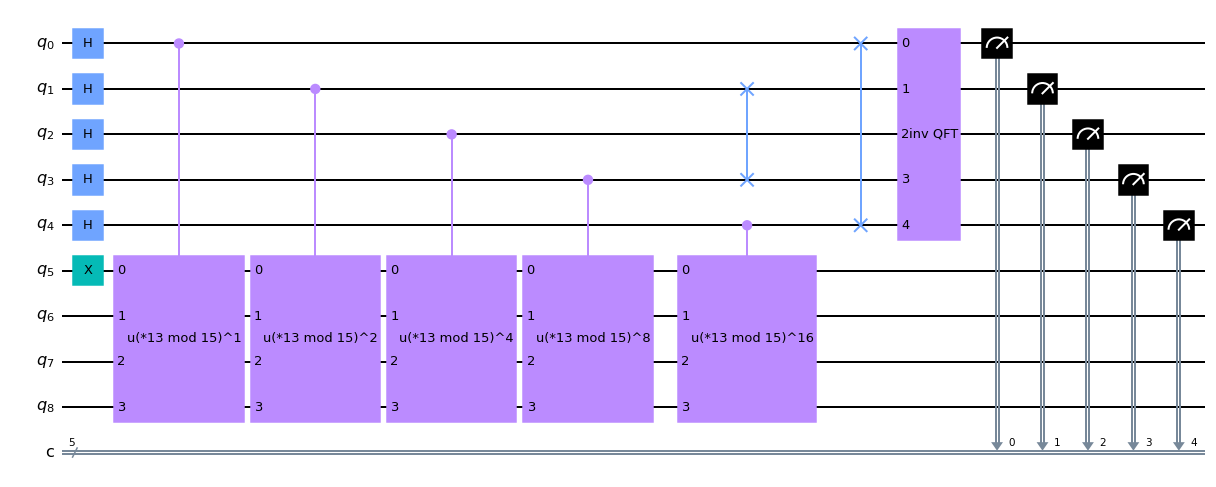

In [86]:
t = 5
l = 4
a = 13
qc = QuantumCircuit(l+t, t)
for i in range(t):
    qc.h(i)
qc.x(t)
for i in range(t):
    qc.append(mod15_power(a, 2**i), [i] + [j+t for j in range(l)])

reverse(qc, t)
qc.append(inv_QFT(t), [i for i in range(t)])
qc.measure(range(t), range(t))
qc.draw('mpl', fold=-1)
    

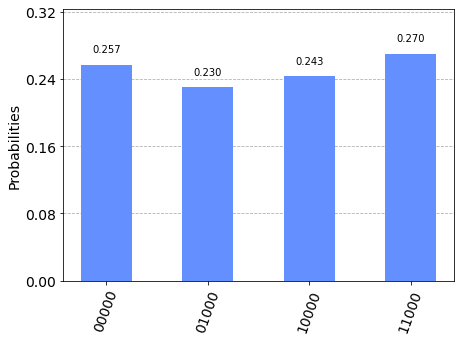

In [87]:
t_qc = transpile(qc, svsim)
qobj = assemble(t_qc)
counts = svsim.run(qobj).result().get_counts()
plot_histogram(counts)

## Order of 4 modulo 15

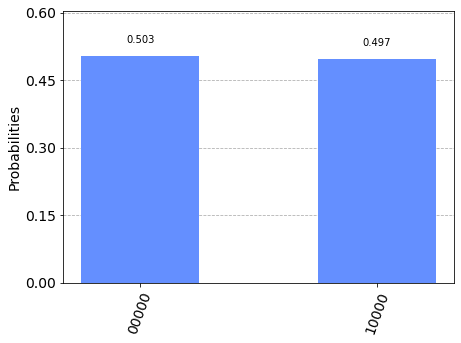

In [88]:
t = 5
l = 4
a = 4
qc = QuantumCircuit(l+t, t)
for i in range(t):
    qc.h(i)
qc.x(t)
for i in range(t):
    qc.append(mod15_power(a, 2**i), [i] + [j+t for j in range(l)])

reverse(qc, t)
qc.append(inv_QFT(t), [i for i in range(t)])
qc.measure(range(t), range(t))
t_qc = transpile(qc, svsim)
qobj = assemble(t_qc)
counts = svsim.run(qobj).result().get_counts()
plot_histogram(counts)

## The output
After running the circuit multiple times, we get the values $2^t\frac{0}{r}, 2^t\frac{1}{r},\ldots, 2^t\frac{r-1}{r}$ roughly equally. So, one way to infer the order is to simply look at the number of "major" measurements in the results, which is not very practical for large numbers. Then, we use the continued fractions algorithm and some other techniques to estimate $r$.

# Factoring 15
After checking that $n$ is not even or of the form $a^b$, a simplified version of the algorithm is to go through numbers between $1$ to $n-1$, and if $(x, n) = 1$, then we find the order of the number modulo $n$.<br>
If the order turns out to be an even number, then $x^r=1\bmod n\implies (x^{r/2}+1)(x^{r/2}-1) = kn$. It can be shown that atleast one of $(x^{r/2}-1, n)$ and $(x^{r/2}+1, n)$ is a non-trivial factor of $n$ when $x\bmod n \neq \pm 1$, which is what we return.

In [92]:
def order_mod_15(a):
    t = 5
    l = 4
    qc = QuantumCircuit(l+t, t)
    for i in range(t):
        qc.h(i)
    qc.x(t)
    for i in range(t):
        qc.append(mod15_power(a, 2**i), [i] + [j+t for j in range(l)])
    reverse(qc, t)
    qc.append(inv_QFT(t), [i for i in range(t)])
    qc.measure(range(t), range(t))
    t_qc = transpile(qc, svsim)
    qobj = assemble(t_qc, shots=1)
    reading = svsim.run(qobj, memory=True).result().get_memory()
    phase = int(reading[0], 2)/(2**t)
    frac = Fraction(phase).limit_denominator(15)
    order = frac.denominator
    return frac, order

for i in range(1, 15):
    if gcd(i, 15) == 1:
        frac, r = order_mod_15(i)
        print(f"Co-prime chosen: {i}, Fraction obtained as s/r: {frac}, Order guessed: {r}")
        if r % 2 == 0:
            print(f"*** Factors guessed: {gcd(i**(r//2) - 1, 15)}, {gcd(i**(r//2) + 1, 15)} ***")

Co-prime chosen: 1, Fraction obtained as s/r: 0, Order guessed: 1
Co-prime chosen: 2, Fraction obtained as s/r: 0, Order guessed: 1
Co-prime chosen: 4, Fraction obtained as s/r: 0, Order guessed: 1
Co-prime chosen: 7, Fraction obtained as s/r: 1/4, Order guessed: 4
*** Factors guessed: 3, 5 ***
Co-prime chosen: 8, Fraction obtained as s/r: 1/4, Order guessed: 4
*** Factors guessed: 3, 5 ***
Co-prime chosen: 11, Fraction obtained as s/r: 1/2, Order guessed: 2
*** Factors guessed: 5, 3 ***
Co-prime chosen: 13, Fraction obtained as s/r: 1/4, Order guessed: 4
*** Factors guessed: 3, 5 ***
Co-prime chosen: 14, Fraction obtained as s/r: 0, Order guessed: 1


As can be seen above, due to the fact that we guess $r$, the order, from an $s/r$ fraction, we can end up guessing the wrong $r$ when the two aren't coprime.